In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import time
import matplotlib.pyplot as plt

In [4]:
# 读取数据

mnist_train = Datasets.FashionMNIST(root='E:/Datasets/FashionMNIST', train=True, download=False, transform=transforms.ToTensor())
mnist_test = Datasets.FashionMNIST(root='E:/Datasets/FashionMNIST', train=False, download=False, transform=transforms.ToTensor())

batch_size = 256
train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [2]:
# 定义模型

# 模型将平均池化改成最大池化，sigmoid改成relu
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c2 = nn.Conv2d(6, 16, kernel_size=5)
        self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fla = nn.Flatten()
        self.l1 = nn.Linear(5 * 5 * 16, 120)
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84, 10)
        
        self.apply(self._init_params)
        
    def _init_params(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            
    def forward(self, X):
        X = self.c1(X)
        X = F.sigmoid(X)
        X = self.p1(X)
        X = self.c2(X)
        X = F.sigmoid(X)
        X = self.p2(X)
        X = self.fla(X)
        X = self.l1(X)
        X = F.relu(X)
        X = self.l2(X)
        X = F.relu(X)
        X = self.l3(X)
        
        return X

In [14]:
# 定义评估准确率函数

def evaluate_accuracy(data_iter, net, device=None):
    net.eval()
    if not device:
        device = net.device
    
    sum_acc = 0.0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            sum_acc += (net(X).argmax(dim=1) == y).float().mean().item()
    
    return sum_acc / len(data_iter)

In [15]:
def my_plot(n_epochs, losses, train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_xlabel('epoch')
    ax.grid(True)
    ax.plot(range(1, n_epochs + 1), losses, label='loss', c='b')
    ax.plot(range(1, n_epochs + 1), train_accs, label='train acc', c='g', linestyle='--')
    ax.plot(range(1, n_epochs + 1), test_accs, label='test acc', c='purple', linestyle='-.')
    
    plt.legend()
    plt.show()

In [16]:
# 定义训练函数

def train(n_epochs, lr, device=None):
    if not device:
        device = net.device
    
    net = LeNet().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    time_sum = 0.0
    losses, train_accs, test_accs =[], [], []
    for epoch in range(n_epochs):
        net.train()
        loss_sum = 0.0
        for X, y in train_iter:
            start = time.time()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            
            time_sum += time.time() - start
            loss_sum += l.item()
        
        train_acc = evaluate_accuracy(train_iter, net, device)
        test_acc = evaluate_accuracy(test_iter, net, device)
        losses.append(loss_sum / len(train_iter))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
        print(f'epoch {epoch + 1: 2d}, loss {loss_sum / len(train_iter): .5f}, train acc {train_acc: .3f}, test acc {test_acc: .3f}')
        
    my_plot(n_epochs, losses, train_accs, test_accs)
    
    print(f'loss {losses[-1]: 5f}, train acc {train_accs[-1]: .3f}, test acc {test_accs[-1]: .3f}')
    print(f'{n_epochs * len(train_iter) * train_iter.batch_size / time_sum: .1f} examples/sec on {str(device)}')
    

epoch  1, loss  1.97505, train acc  0.595, test acc  0.596
epoch  2, loss  0.80753, train acc  0.736, test acc  0.726
epoch  3, loss  0.58341, train acc  0.800, test acc  0.797
epoch  4, loss  0.47415, train acc  0.824, test acc  0.817
epoch  5, loss  0.42616, train acc  0.840, test acc  0.830
epoch  6, loss  0.39404, train acc  0.849, test acc  0.840
epoch  7, loss  0.37275, train acc  0.856, test acc  0.845
epoch  8, loss  0.35611, train acc  0.862, test acc  0.849
epoch  9, loss  0.34248, train acc  0.860, test acc  0.846
epoch  10, loss  0.33075, train acc  0.864, test acc  0.852


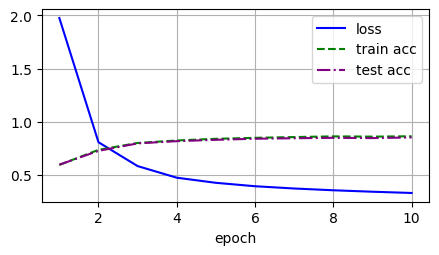

loss  0.330753, train acc  0.864, test acc  0.852
 73690.6 examples/sec on cuda


In [17]:

train(10, 0.9, torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))